In [64]:
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt 


In [65]:
df = pd.read_excel("appointment_prediction_data.xlsx")
df['No-show'].replace({'Yes': 0, 'No': 1}, inplace=True)

df.rename(columns={'No-show': 'Compareceu'}, inplace=True)

df['Gender'].replace({'Female':'F','Male':'M'}, inplace=True)

df['Neighbourhood'].replace({'RESIST√äNCIA':'RESISTÊNCIA','REP√öBLICA':'REPÚBLICA','S√ÉO PEDRO':'SÃO PEDRO',
                             'S√ÉO CRIST√ìV√ÉO':'SÃO CRISTÓVÃO','MARU√çPE':'MARUÍPE','GRANDE VIT√ìRIA':'GRANDE VITÓRIA',
                             'S√ÉO BENEDITO':'SÃO BENEDITO','SANTO ANDR√â':'SANTO ANDRÉ','ANT√îNIO HON√ìRIO':'ANTÔNIO HONÓRIO',
                             'M√ÅRIO CYPRESTE':'MARIO CYPRESTE','SANTO ANT√îNIO':'SANTO ANTONIO','PRAIA DO SU√Å':'PRAIA DO SUÁ',
                             'ITARAR√â':'ITARARA','INHANGUET√Å':'INHAGUETA','UNIVERSIT√ÅRIO':'UNIVERSITARIO',
                             'S√ÉO JOS√â':'SÃO JOSÉ','REDEN√á√ÉO':'REDENÇÃO','CARATO√çRA':'CARATOÍRA',
                             'ILHA DO PR√çNCIPE': 'ILHA DO PRÍNCIPE','ROM√ÉO': 'ROMÃO', 'FORTE S√ÉO JO√ÉO': 'FORTE SÃO JOÃO',
                             'JOANA D¬¥ARC': 'JOANA D\'ARC','CONSOLA√á√ÉO': 'CONSOLAÇÃO', 'SANTA CEC√çLIA': 'SANTA CECÍLIA',
                             'SANTA L√öCIA': 'SANTA LÚCIA','SANTA LU√çZA': 'SANTA LUÍZA', 'SEGURAN√áA DO LAR': 'SEGURANÇA DO LAR',
                             'Tabuazerio': 'TABUAZEIRO','ILHAS OCE√ÇNICAS DE TRINDADE': 'ILHAS OCEÂNICAS DE TRINDADE',
                             'ENSEADA DO SU√Å': 'ENSEADA DO SUÁ'}, inplace=True)
df['Neighbourhood'] = df.Neighbourhood.str.upper()

df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date

df['time_delta'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

df['Handcap'].replace(to_replace = (2 ,3 ,4), value = 1 , inplace = True)
df['Handcap'].value_counts()

df.drop_duplicates(subset='AppointmentID', keep='first')

df.dropna(subset=["Age"], inplace=True)

Em comparação ao grupo não-PCD, o grupo com deficiência compareceu mais nas consultas.

In [66]:
# O grupo PCD compareceu mais que o grupo não-PCD nas consultas.
df.groupby(['Handcap'])['Compareceu'].mean() 

Handcap
0    0.797647
1    0.818669
Name: Compareceu, dtype: float64

Quantas consultas foram marcadas para cada especialidade?

In [67]:

df_pcd = df.loc[df['Handcap']==1]


hipertensos_pcd = df_pcd.loc[df_pcd['Hipertension']==1]
alcolismo_pcd = df_pcd.loc[lista_deficientes['Alcoholism']==1]
diabetes_pcd = df_pcd.loc[lista_deficientes['Diabetes']==1]

print(f'Foram {len(alcolismo_pcd)} consultas marcadas para Alcoolismo no grupo PCD')
print(f'Foram {len(diabetes_pcd)} consultas marcadas para Diabetes no grupo PCD')
print(f'Foram {len(hipertensos_pcd)} consultas marcadas para Hipertensão no grupo PCD')


Foram 78 consultas marcadas para Alcoolismo no grupo PCD
Foram 398 consultas marcadas para Diabetes no grupo PCD
Foram 966 consultas marcadas para Hipertensão no grupo PCD


Qual gênero compareceu mais nas consultas marcadas no grupo PCD?

In [77]:
#média de comparecimentos por sexo no grupo PCD
df_pcd.groupby('Gender')['Compareceu'].mean()

Gender
F    0.812258
M    0.827368
Name: Compareceu, dtype: float64

Qual a faixa etária que mais compareceu nas consultas marcadas?

In [82]:
df_pcd['Faixa etária']=pd.cut(df_pcd.['Age'],bins=[-1,12,18,30,60,125],labels=['Crianças','Adolescentes','Jovens Adultos','Adultos','Idosos'])
df_pcd.groupby(['Faixa etária'])['Compareceu'].mean().sort_values(ascending=False)

C:\Users\milla\AppData\Local\Temp\ipykernel_4444\1879175599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pcd['Faixa etária']=pd.cut(df_pcd['Age'],bins=[-1,12,18,30,60,125],labels=['Crianças','Adolescentes','Jovens Adultos','Adultos','Idosos'])


Faixa etária
Adultos           0.837809
Idosos            0.835966
Jovens Adultos    0.798165
Adolescentes      0.769231
Crianças          0.622449
Name: Compareceu, dtype: float64

No geral, incluindo TODAS as consultas, até as imediatas, receber o sms não impactou o grupo PCD, porém se isolarmos as consultas imediatas vemos que sim teve uma pequena diferença, e vamos ver isso mais a frente.

In [99]:
df_pcd.groupby(['SMS_received'])['Compareceu'].mean()

SMS_received
0    0.840376
1    0.749533
Name: Compareceu, dtype: float64

Alocando as respostas de comparecimentos em grupos de:<br>
Recebeu o sms - 1. Não recebeu o sms - 0.<br>
<br>
E separando o grupo por consultas realizadas a partir de 3 dias de marcação temos os seguintes resultados:

No grupo de consultas marcadas para "Diabetes" houve um aumento de 7% no comparecimento de quem recebeu o lembrete por sms.

In [98]:
#Do grupo do diabetes que recebeu mensagem: 79,16% compareceu e 20,84% não compareceu
sms_diabetes_pcd = diabetes_pcd.loc[(diabetes_pcd['time_delta']>2)]
sms_diabetes_pcd.groupby(['SMS_received'])['Compareceu'].mean()

SMS_received
0    0.720000
1    0.791667
Name: Compareceu, dtype: float64

No grupo de consultas marcadas para "Hipertensão" houve um aumento de 7% no comparecimento de quem recebeu o lembrete por sms. 

In [97]:

sms_hipertensao = hipertensos_pcd.loc[(hipertensos_pcd['time_delta']>2)]
sms_hipertensao.groupby(['SMS_received'])['Compareceu'].mean()

SMS_received
0    0.707547
1    0.780303
Name: Compareceu, dtype: float64

No grupo de consultas marcadas para "Alcoolismo" receber SMS não fez diferença.

In [96]:
sms_alcolismo_pcd = alcolismo_pcd.loc[(alcolismo_pcd['time_delta']>3)]
sms_alcolismo_pcd.groupby(['SMS_received'])['Compareceu'].mean()

SMS_received
0    0.941176
1    0.882353
Name: Compareceu, dtype: float64

Será que com o tempo mais longo de espera de consulta há mais ausência de deficientes?

In [100]:
df_pcd.groupby(['time_delta'])['Compareceu'].value_counts()

time_delta  Compareceu
-1          0               2
 0          1             861
            0              71
 1          1              97
            0              24
                         ... 
 122        1               1
 142        0               1
            1               1
 155        0               1
 179        0               1
Name: Compareceu, Length: 140, dtype: int64

O nível de comparecimento é alto nos primeiros dias, mas quanto mais longe da data a consulta é marcada, as taxas de comparecimento diminuem.

<AxesSubplot:title={'center':'Comparecimento por tempo de espera'}, xlabel='time_delta'>

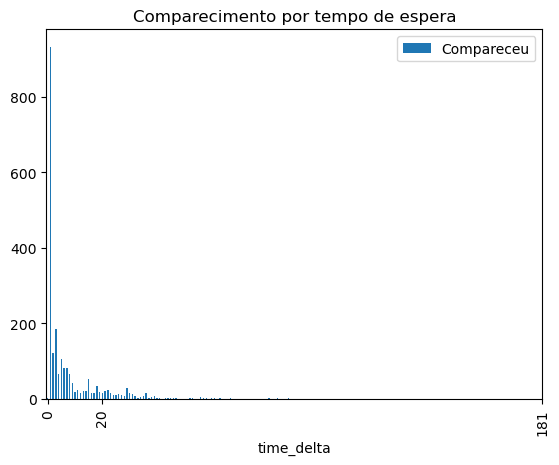

In [102]:
df_pcd.pivot_table(index='time_delta', aggfunc='count', values='Compareceu').plot(kind='bar', xticks= (np.arange(0,130,30)), title = 'Comparecimento por tempo de espera pela consulta', xlabel = 'Dias depois da marcação')

Solução: Quanto mais cedo as consultas forem marcadas, e tendo sido reforçados os lembretes por sms, a taxa de AUSÊNCIA do grupo PCD diminuirá.